# Dog and cat audio classification

## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import os
import librosa 
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import tensorflow.keras.layers as layers
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score

import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd

## Help funcs

In [2]:
def graph_count_animal_each_species(data):
    plt.figure(figsize=(8,6),dpi=80)
    # sns.set_theme(style="darkgrid")
    sns.countplot(x="species",data=data)
    plt.title('cats = '+str(data.species.value_counts()[0])+
          ', dogs = '+str(data.species.value_counts()[1]))
    plt.show()

def show_mfcc(path_to_file):
      y, sr = librosa.load(path_to_file)
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

      import matplotlib.pyplot as plt
      plt.figure(figsize=(10, 4))
      librosa.display.specshow(mfccs, x_axis='time')
      plt.colorbar()
      plt.title(f'{path_to_file}')
      plt.tight_layout()

def time_audio_presentation(audio):
    audio = audio / np.max(np.abs(audio))
    return audio
    
def show_fft(y, fs):
    from scipy.fftpack import fft
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

## Creation of Training Set

In [3]:
import os

ID=[]
label=[]
directory = 'Data/cats_dogs/train/'
 
for folder in os.listdir(directory):                               
    for filename in os.listdir(directory+str(folder)):          
        f = os.path.join(directory+str(folder), filename)  
        if os.path.isfile(f):
            ID.append(f.split('/')[-1])
            label.append(f.split('/')[-2])

In [4]:
train_data=pd.DataFrame()
train_data['ID']=ID
train_data['species']=label

In [5]:
train_data

,ID,species
0,cat_74.wav,cat
1,cat_60.wav,cat
2,cat_48.wav,cat
3,cat_132.wav,cat
4,cat_127.wav,cat
...,...,...
205,dog_barking_84.wav,dog
206,dog_barking_102.wav,dog
207,dog_barking_103.wav,dog
208,dog_barking_85.wav,dog


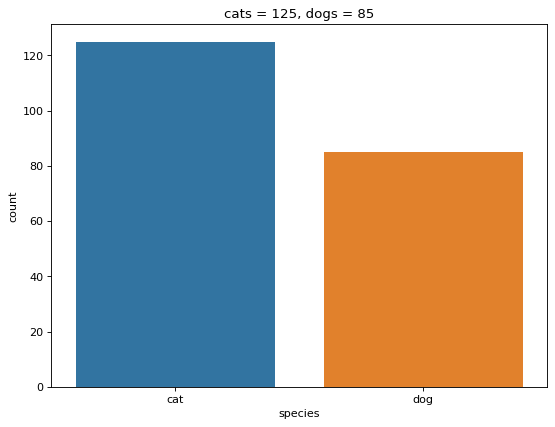

In [6]:
graph_count_animal_each_species(train_data)

## Creation of Test Set

In [7]:
ID=[]
label=[]
# import required module
import os
# assign directory
directory = 'Data/cats_dogs/test/'
 
# iterate over files in
# that directory

for folder in os.listdir(directory):
    for filename in os.listdir(directory+str(folder)):
        f = os.path.join(directory+str(folder), filename)
        if os.path.isfile(f):
            ID.append(f.split('/')[-1])
            label.append(f.split('/')[-2])

In [8]:
test_data=pd.DataFrame()
test_data['ID']=ID
test_data['species']=label

In [9]:
test_data 

,ID,species
0,dog_barking_89.wav,dogs
1,dog_barking_62.wav,dogs
2,dog_barking_48.wav,dogs
3,dog_barking_49.wav,dogs
4,dog_barking_59.wav,dogs
...,...,...
62,cat_129.wav,cats
63,cat_115.wav,cats
64,cat_85.wav,cats
65,cat_86.wav,cats


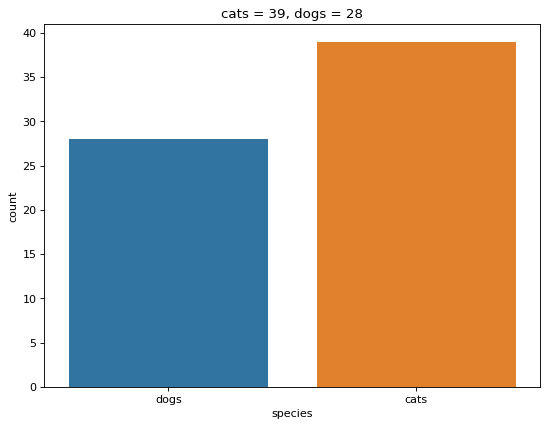

In [10]:
graph_count_animal_each_species(test_data)

## MFCC theory

https://habr.com/ru/post/140828/

https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial/notebook

MFCC (Мел-кепстральные коэффициенты) - это способ извлечения функций из звука. 

Mел – единица высоты звука, основанная на восприятии этого звука нашими органами слуха.

MFCC использует шкалу MEL для разделения полосы частот на поддиапазоны, а затем извлекает кепстральные коэффициенты с помощью дискретного косинусного преобразования (DCT). 



Шкала MEL основана на способе, которым люди различают частоты, что делает обработку звуков очень удобной.

In [11]:
audio_rate, audio = wavfile.read("Data/cats_dogs/test/cats/cat_79.wav")
print("Sample rate: {0}Hz".format(audio_rate))
print("Audio duration: {0}s".format(len(audio) / audio_rate))

Sample rate: 16000Hz
Audio duration: 13.388s


### Временное представление

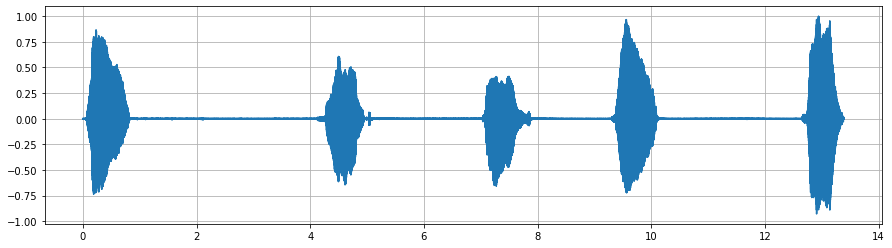

In [12]:
audio = time_audio_presentation(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / audio_rate, num=len(audio)), audio)
plt.grid(True)

### Cпектр исходного сигнала (получаем с помощью преобразования Фурье)

Аудио кадрирование


Поскольку звук - это нестационарный процесс, FFT вызывает искажения. Чтобы преодолеть это, мы можем предположить, что звук является стационарным процессом в течение коротких периодов времени. Из-за этого мы разбиваем сигнал на короткие кадры. Каждый аудио-кадр будет того же размера, что и FFT. Также мы хотим, чтобы кадры перекрывались. Потому, что мы теряем информацию по краям каждого кадра после применения оконной функции.


Audio Framing


Because audio is a non stationary process, the FFT will produce distortions. To overcome this we can assume that the audio is a stationary process for a short periods of time. Because of that we devide the signal into short frames. Each audio frame will be the same size as the FFT. Also we want the frames to overlap. We do that so that the frames will have some correlation between them and because we loose the information on the edges of each frame after applying a window function.

In [13]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=audio_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (893, 2048)


Преобразование в частотную область


Теперь мы преобразуем звук, который в настоящее время находится во временной области, в частотную область. FFT предполагает, что звук является периодическим, и продолжительным. Кадрируя сигнал, мы гарантировали, что звук будет периодическим. Чтобы звук был продолжительным, мы применяем оконную функцию к каждому кадру. Если мы этого не сделаем, мы получим высокочастотные искажения. Чтобы преодолеть это, нам сначала нужно применить оконную функцию к кадрированному звуку, а затем выполнить FFT. Окно гарантирует, что оба конца сигнала будут близки к нулю.


Convert to frequency domain


Now we will convert the audio, which is currently in the time domain, to frequency domain. The FFT assumes the audio to be periodic and continues. By framing the signal we assured the audio to be periodic. To make the audio continues, we apply a window function on every frame. If we wont do that, We will get high frequency distortions. To overcome this, we first need to apply a window function to the framed audio and then perforn FFT. The window assures that both ends of the signal will end close to zero.

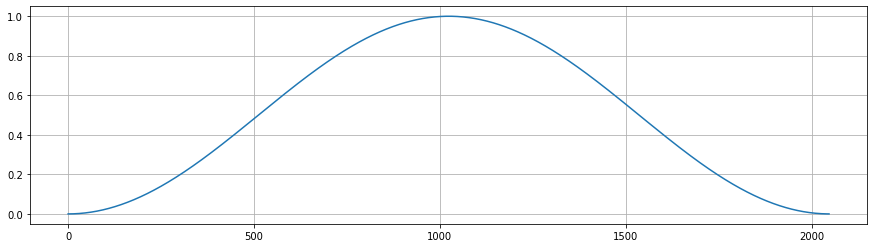

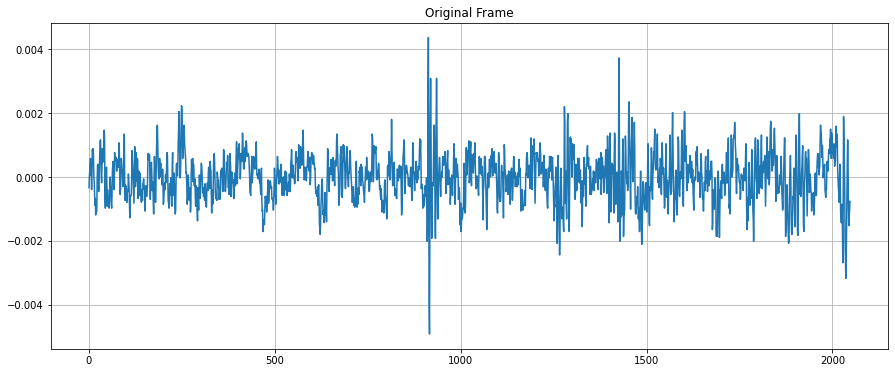

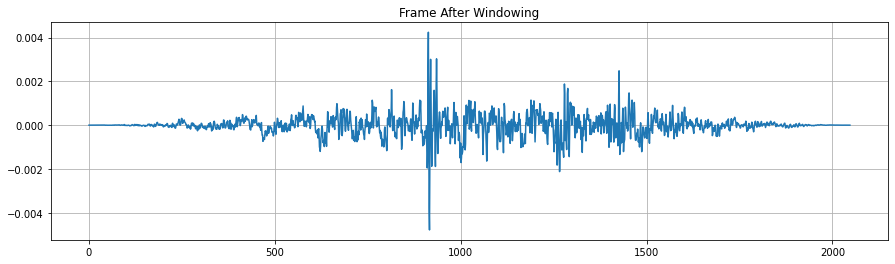

In [14]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))

plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)

plt.figure(figsize=(15,4))


plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In the plot above you can see the that both ends of the frame end on different places on the y axis. You can see that the window brought the edges of each frame closer to zero.

Now lets perform the FFT. After we do the FFT we only take the the positive part of the spectrum (first half +1).


На графике выше вы можете видеть, что оба конца кадра заканчиваются в разных местах по оси Y. Вы можете видеть, что в окне края каждого кадра приблизились к нулю.

Теперь давайте выполним FFT. После выполнения FFT мы берем только положительную часть спектра (первая половина +1).

In [15]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(893, 1025)


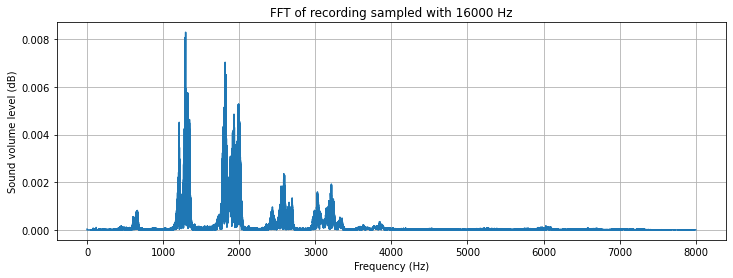

In [16]:
xf, vals = show_fft(audio, audio_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(audio_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Sound volume level (dB)')
plt.grid()
plt.show()

### Полученный спектр распологаем на мел-шкале

MEL-spaced filterbank


Here we compute the MEL-spaced filterbank and then pass the framed audio through them. That will give us information about the power in each frequency band. The filters can be constructed for any frequency band but for our example we will look on the entire sampled band.

What spessial with the MEL-spaced filterbank is the spacing between the filters which grows exponentially with frequency. The filterbank can be made for any frequency band. Here we will compute the filterbank for the entire frequency band.


Набор фильтров с разнесением MEL


Здесь мы вычисляем набор фильтров, разнесенных на MEL, а затем пропускаем через них кадрированный звук. Это даст нам информацию о мощности в каждой полосе частот. Фильтры могут быть созданы для любой полосы частот, но в нашем примере мы будем рассматривать всю полосу дискретизации.

Что характерно для набора фильтров с разнесением MEL, так это расстояние между фильтрами, которое экспоненциально растет с частотой. Набор фильтров можно сделать для любой полосы частот. Здесь мы вычислим набор фильтров для всей полосы частот.

In [17]:
freq_min = 0
freq_high = audio_rate / 2
mel_filter_num = 10

FFT_size = 2048

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))


Minimum frequency: 0
Maximum frequency: 8000.0


Compute filter points


First we construct filter points that determines the start and stop of the filters. To do that we first convert the two filterbank edges to the MEL space. After that we construct a lineary spaced array between the two MEL frequencies. Then we convert the array to the frequency space and finally we normalize the array to the FFT size and choose the associated FFT values.


Вычисляем точки фильтрации


Сначала мы создаем точки фильтра, которые определяют начало и конец фильтров. Для этого мы сначала преобразуем два края filterbank в пространство MEL. После этого мы строим линейный массив между двумя частотами MEL. Затем мы преобразуем массив в частотное пространство и, наконец, нормализуем массив до размера FFT и выбираем связанные значения FFT.

MEL min: 0.0
MEL max: 2840.023046708319


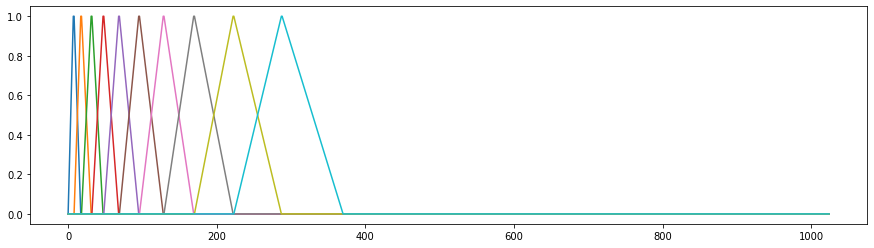

In [18]:

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

# Construct the filterbank
# After we have the filter points, we construct the filters.

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

Next we divide the triangular MEL weights by the width of the MEL band (area normalization). If we wont normalize the filters, we will see the noise increase with frequency because of the filter width.

Затем мы делим треугольные веса MEL на ширину полосы MEL (нормализация площади). Если мы не будем нормализовать фильтры, мы увидим, что шум увеличивается с частотой из-за ширины фильтра.

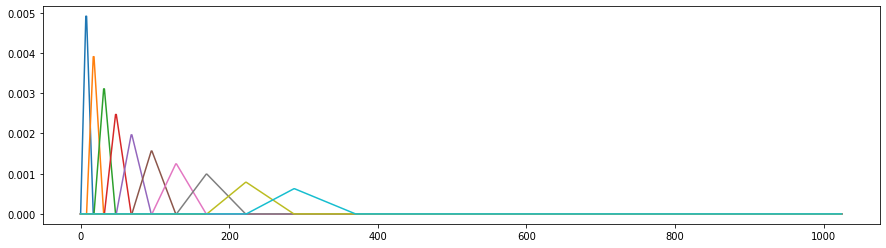

In [19]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [20]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

# Now we have a matrix represemting the audio power in all 10 filters in different time frames.




(40, 893)

### Generate the Cepstral Coefficents


The final step in generating the MFCC is to use the Discrete Cosine Transform (DCT). We will use the DCT-III. This type of DCT will extract high frequency and low frequency changes in the the signal

In [ ]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

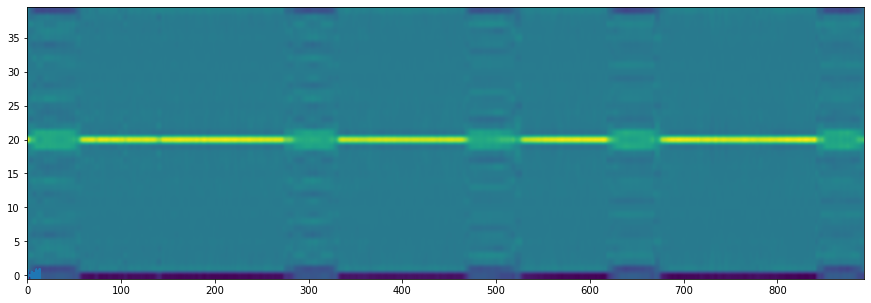

In [21]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / audio_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

## Feature extraction of audio files using MFCCs

In [22]:
def extract_features(directory):
    features=[]
    ID=[]
    for folder in os.listdir(directory):
        for filename in os.listdir(directory+str(folder)):
            f = os.path.join(directory+str(folder), filename)
            if os.path.isfile(f):
                x,sr=librosa.load(f, res_type='kaiser_fast',sr=None)
                mfccs=np.mean(librosa.feature.mfcc(x,sr=sr,n_mfcc=100).T,axis=0)
                features.append(mfccs)
                ID.append(f.split('/')[-1])
    return [ID, features]

In [23]:
ID, features_train=extract_features('Data/cats_dogs/train/')

This step is required to check that the ID's that we obtained from extract_features function are matching with the actual ID's in train_data that we created earlier such that there's no mismatch of data rows.

In [24]:
print(np.count_nonzero(train_data.ID==ID) )
len(train_data.ID)==np.count_nonzero(train_data.ID==ID) 


210


True

In [25]:
ID,features_test=extract_features('Data/cats_dogs/test/')
len(test_data.ID)==np.count_nonzero(test_data.ID==ID)   #matched 

True

## Create X_train, Y_train & X_test, Y_test

In [26]:
X_train=np.array(features_train)
X_test=np.array(features_test)

Y_train=train_data.species
Y_test=test_data.species

In [27]:
le=LabelEncoder()

temp=le.fit_transform(Y_train)
Y_train=temp.reshape(-1,1)

temp=le.fit_transform(Y_test)
Y_test=temp.reshape(-1,1)

In [28]:
print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)   

(210, 100) (67, 100)
(210, 1) (67, 1)


## Build audio classification model

* For simulation, we will use a convolutional neural network with 4 layers. 

* To keep the model simple, we'll start by creating a sequential Sequential model. 

* Add 4 dense layers. 
* * The first 3 with the size of the output space as 200, the activation function = 'relu'. 
* * Last 4 with source space size as 1, activation function = 'sigmoid'


* The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero.



In [29]:
model=tf.keras.Sequential()
model.add(layers.Dense(input_shape=(100,), units= 200,activation='relu'))
model.add(layers.Dense(200,activation='relu'))
model.add(layers.Dense(200,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 100,801
Trainable params: 100,801
Non-trainable params: 0
_________________________________________________________________


2021-11-21 19:27:50.891927: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
hist=model.fit(X_train,Y_train,epochs=100)

2021-11-21 19:27:51.072087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
7/7 [==============================] - 1s 2ms/step - loss: 3.7489 - accuracy: 0.6000
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9127 - accuracy: 0.8095
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5759 - accuracy: 0.8429
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4530 - accuracy: 0.8429
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6972 - accuracy: 0.8714
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8287 - accuracy: 0.7857
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8350 - accuracy: 0.7714
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3132 - accuracy: 0.9048
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.9238
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.9476
Epoch 11/100
7/7 [===========

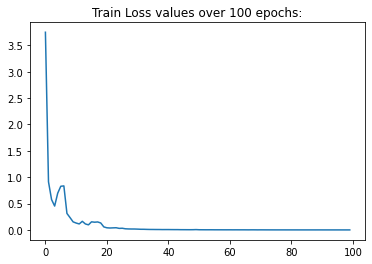

In [32]:
plt.title('Train Loss values over 100 epochs:')
plt.plot(hist.history['loss'])
plt.show()

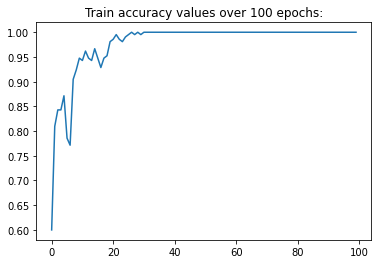

In [33]:
plt.title('Train accuracy values over 100 epochs:')
plt.plot(hist.history['accuracy'])
plt.show()

## Testing the model with test data (Confusion matrix)

In [34]:
Y_pred=model.predict(X_test)
Y_pred=(Y_pred>0.5)*1


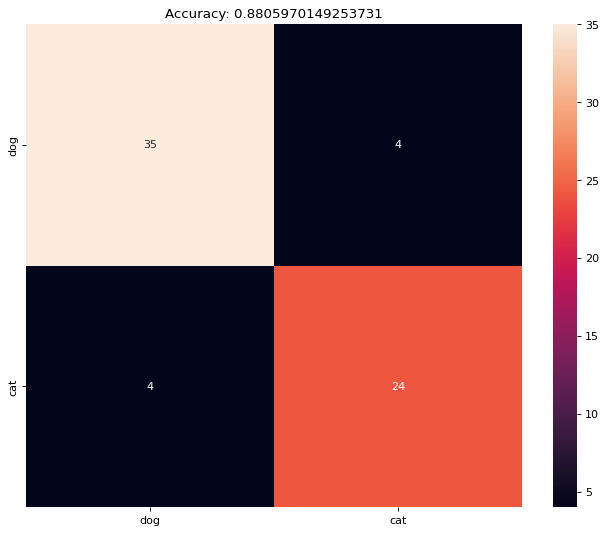

In [35]:
plt.figure(figsize=(10,8),dpi=80)
sns.heatmap(confusion_matrix(Y_test,Y_pred),annot=True, xticklabels=["dog","cat"], yticklabels=["dog","cat"])
plt.title(f'Accuracy: {accuracy_score(Y_test,Y_pred)}')
plt.show()

## Full classification report

In [36]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        39
           1       0.86      0.86      0.86        28

    accuracy                           0.88        67
   macro avg       0.88      0.88      0.88        67
weighted avg       0.88      0.88      0.88        67

